In [2]:
#pip install rich~=12.5 numpy~=1.21 pandas~=1.3 pyarrow~=15.0 matplotlib~=3.5.0 seaborn~=0.11 scikit-learn~=1.0 spectrum_utils==0.3.5 hyperopt~=0.2 --quiet

In [3]:
## https://proteomicsml.org/tutorials/fragmentation/nist-1-parsing-spectral-library.html

In [1]:
## Imports
import tarfile
import urllib
import re

from rich import print, progress

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import spectrum_utils.spectrum as sus
import spectrum_utils.plot as sup

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor

from hyperopt import fmin, hp, tpe, STATUS_OK

np.random.seed(42)

### Pre-Processing the data

In [2]:
library_file = "human_hcd_tryp_best.msp"

In [4]:
## Downloading the dataset
# url = "https://chemdata.nist.gov/download/peptide_library/libraries/human/HCD/2020_05_19/human_hcd_tryp_best.msp.tar.gz"

# # Download file
# _ = urllib.request.urlretrieve(url, f"{library_file}.tar.gz")

with tarfile.open(f"{library_file}.tar.gz") as f:
    f.extractall("./datasets/")

In [5]:
dataset_location = "./datasets/" + f"{library_file}"
dataset_location

'./datasets/human_hcd_tryp_best.msp'

In [6]:
## First 10 lines of the dataset
with open(dataset_location, "rt") as f:
    for i, line in enumerate(f):
        print(line.strip())
        if i > 10:
            break

Name: AAAAAAAAAAAAAAAGAGAGAK/2_0

Comment: Consensus Pep=Tryptic Peptype=<Protein><Peptide><Protein> Mods=0 Fullname=R.AAAAAAAAAAAAAAAGAGAGAK.Q 
Charge=2 Parent=798.9263 CE=42.09 NCE=29.43 Q-value=0.0000 Nprot=1 Protein="sp|P55011|S12A2_HUMAN(pre=R,post=Q)" 
Nrep=134/200 Theo_mz_diff=1.2ppm Quality=7/7 MC=0 MCtype=Normal Unassigned_all_20ppm=0.1424 Unassigned_20ppm=0.0416
num_unassigned_peaks_20ppm=44 max_unassigned_ab_20ppm=0.41 top_20_num_unassigned_peaks_20ppm=1/20

Num peaks: 117

110.0712        259243.2        "? 143/200"

115.0864        97764.4 "a2/-1.6ppm 145/200"

116.0704        26069.5 "? 80/200"

120.0806        208924.4        "? 148/200"

129.0657        25535.9 "Int/AG/-1.2ppm,Int/GA/-1.2ppm 86/200"

129.1021        361336.8        "IKD/-1.1ppm,y1-H2O/-1.1ppm 172/200"

130.0860        120990.5        "y1-NH3/-1.9ppm 123/200"

136.0754        401263.5        "? 147/200"

141.1019        54146.8 "? 113/200"

### Parsing the spectral peak library file

In [9]:
def read_msp(filename):
    """Iterate over MSP spectral library file and return spectra as dicts."""
    spectrum = {}
    mz = []
    intensity = []
    annotation = []

    with progress.open(filename, "rt") as f:
        for line in f:
            # `Name: ` is the first line of a new entry in the file
            if line.startswith("Name: "):
                if spectrum:
                    # Finalize and yield previous spectrum
                    spectrum["sequence"] = spectrum["Fullname"].split(".")[1]  # Remove the previous/next amino acids
                    spectrum["mz"] = np.array(mz, dtype="float32")
                    spectrum["intensity"] = np.array(intensity, dtype="float32")
                    spectrum["annotation"] = np.array(annotation, dtype="str")
                    yield spectrum

                    # Define new spectrum
                    spectrum = {}
                    mz = []
                    intensity = []
                    annotation = []

                # Extract everything after `Name: `
                spectrum["Name"] = line.strip()[6:]

            elif line.startswith("Comment: "):
                # Parse all comment items as metadata
                metadata = [i.split("=") for i in line[9:].split(" ")]
                for item in metadata:
                    if len(item) == 2:
                        spectrum[item[0]] = item[1]

            elif line.startswith("Num peaks: "):
                spectrum["Num peaks"] = int(line.strip()[11:])

            elif len(line.split("\t")) == 3:
                # Parse peak list items one-by-one
                line = line.strip().split("\t")
                mz.append(line[0])
                intensity.append(line[1])
                annotation.append(line[2].strip('"'))

    # Final spectrum
    spectrum["sequence"] = spectrum["Fullname"].split(".")[1]  # Remove the previous/next amino acids
    spectrum["mz"] = np.array(mz, dtype="float32")
    spectrum["intensity"] = np.array(intensity, dtype="float32")
    spectrum["annotation"] = np.array(annotation, dtype="str")
    yield spectrum

In [10]:
for spectrum in read_msp("human_hcd_tryp_best.msp"):
    print(spectrum["Name"])
    break

/Users/saugatmalla/Library/Mobile 
Documents/com~apple~CloudDocs/Documents/NEU-Courses/Sem_4/Microbe/.venv/lib/python3.10/site-packages/rich/live.py:2
29: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')
Reading... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/2.0 GB -:--:--

AAAAAAAAAAAAAAAGAGAGAK/2_0
Reading... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/2.0 GB -:--:--

In [11]:
pd.DataFrame({
    "mz": spectrum["mz"],
    "intensity": spectrum["intensity"],
    "annotation": spectrum["annotation"]
})

,mz,intensity,annotation
0,110.071198,259243.203125,? 143/200
1,115.086403,97764.398438,a2/-1.6ppm 145/200
2,116.070396,26069.500000,? 80/200
3,120.080597,208924.406250,? 148/200
4,129.065704,25535.900391,"Int/AG/-1.2ppm,Int/GA/-1.2ppm 86/200"
...,...,...,...
112,1170.621338,442693.312500,y16/-1.1ppm 180/200
113,1171.624146,173247.703125,y16+i/-1.0ppm 133/200
114,1241.657959,264065.593750,y17/-1.3ppm 170/200
115,1242.660156,112235.101562,y17+i/-1.8ppm 125/200


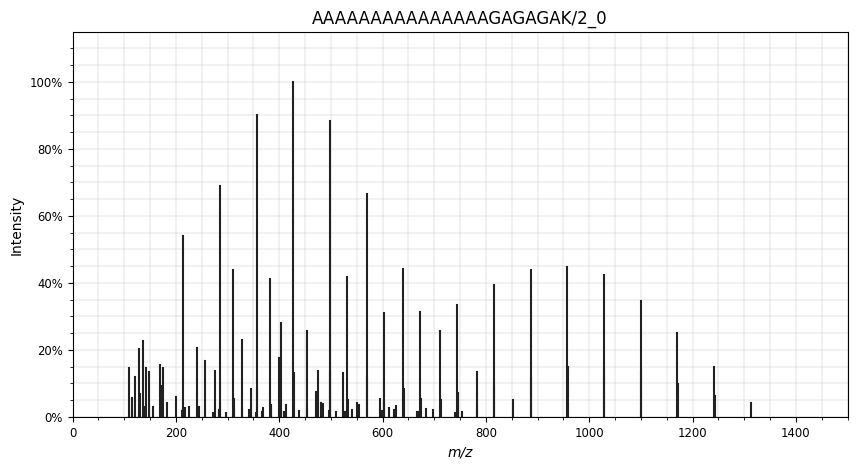

In [12]:
plt.figure(figsize=(10,5))

sup.spectrum(
    sus.MsmsSpectrum(
        identifier = spectrum['Name'],
        precursor_mz = float(spectrum['Parent']),
        precursor_charge = int(spectrum['Charge']),
        mz = spectrum['mz'],
        intensity = spectrum['intensity']
    )
)
plt.title(spectrum['Name'])
plt.show()

### Preparing Spectra for training

In [13]:
# 1. Normalize the intensities
## TIC Normalization
def tic_normalize(msp_spectrum):
    tic = np.sum(msp_spectrum['intensity'])
    msp_spectrum['intensity'] = msp_spectrum['intensity'] / tic

# Before normalization
print(f"Before Normalization: {spectrum['intensity'][:10]}")
# After normalization
tic_normalize(spectrum)
print(f"After Normalization: {spectrum['intensity'][:10]}")

Before Normalization: [259243.2  97764.4  26069.5 208924.4  25535.9 361336.8 120990.5 401263.5
  54146.8 259764.2]

After Normalization: [0.00882945 0.00332971 0.00088789 0.00711566 0.00086972 0.0123066
 0.00412076 0.01366645 0.00184416 0.00884719]

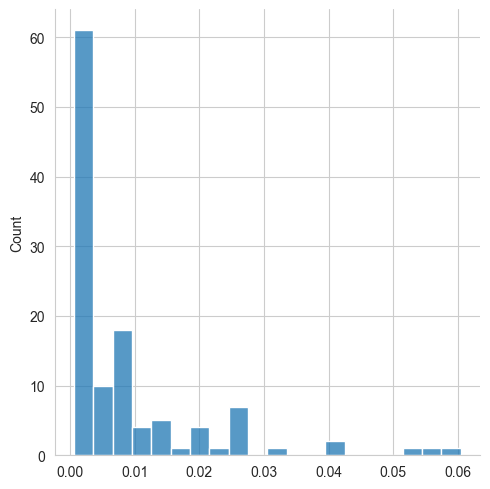

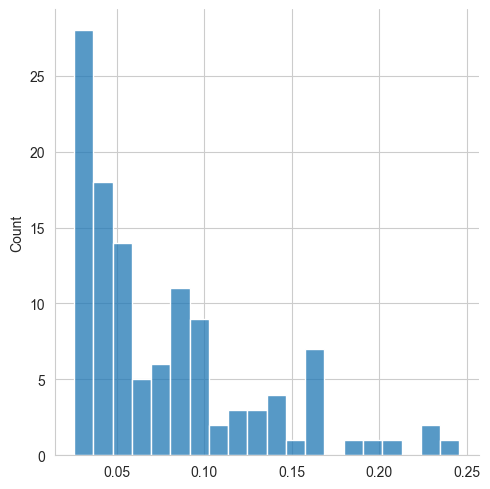

In [14]:
# 2. Transform the intensities
## Square root transform

sns.set_style("whitegrid")

# Before transform
sns.displot(spectrum['intensity'], bins=20)
plt.show()

# After transform
def sqrt_transform(msp_spectrum):
    msp_spectrum['intensity'] = np.sqrt(msp_spectrum['intensity'])

# After transform
sqrt_transform(spectrum)
sns.displot(spectrum['intensity'], bins=20)
plt.show()

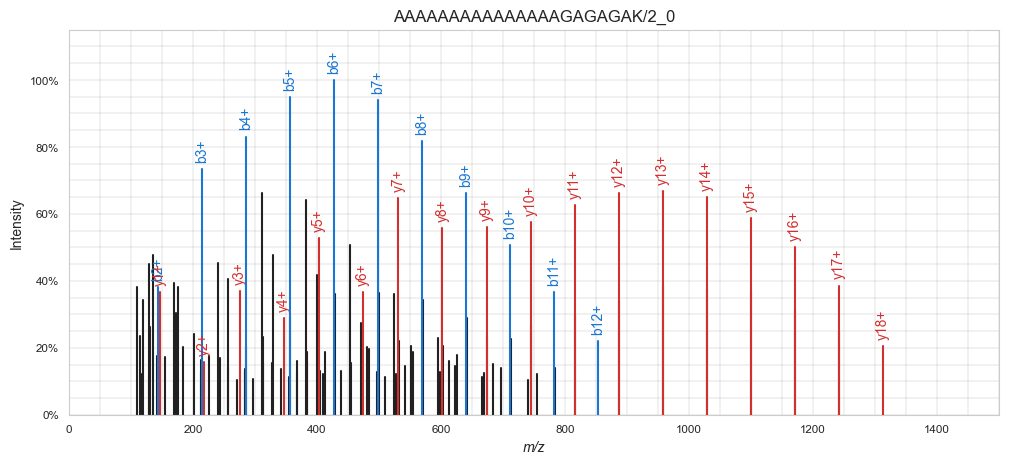

In [15]:
# 3. Annotate the peak
plt.figure(figsize=(12, 5))
sup.spectrum(
    sus.MsmsSpectrum(
        identifier = spectrum['Name'], 
        precursor_mz = float(spectrum['Parent']),
        precursor_charge = int(spectrum['Charge']), 
        mz = spectrum['mz'],
        intensity = spectrum['intensity'],
        peptide = spectrum['sequence']
    ).annotate_peptide_fragments(25, 'ppm')
)
plt.title(spectrum["Name"])
plt.show()

In [16]:
# 4. Parse the relevant peak intensities to an format suitable for machine learning
## Using regex

def filter_peaks(msp_spectrum):
    """Filter spectrum peaks to only charge 1 b- and y ions"""
    # Generate boolean mask
    get_mask = np.vectorize(lambda x: bool(re.match("^(b|y)([0-9]+)\/" , x)))
    mask = get_mask(msp_spectrum['annotation'])

    msp_spectrum['annotation'] = msp_spectrum['annotation'][mask]
    msp_spectrum['mz'] = msp_spectrum['mz'][mask]
    msp_spectrum['intensity'] = msp_spectrum['intensity'][mask]

filter_peaks(spectrum)

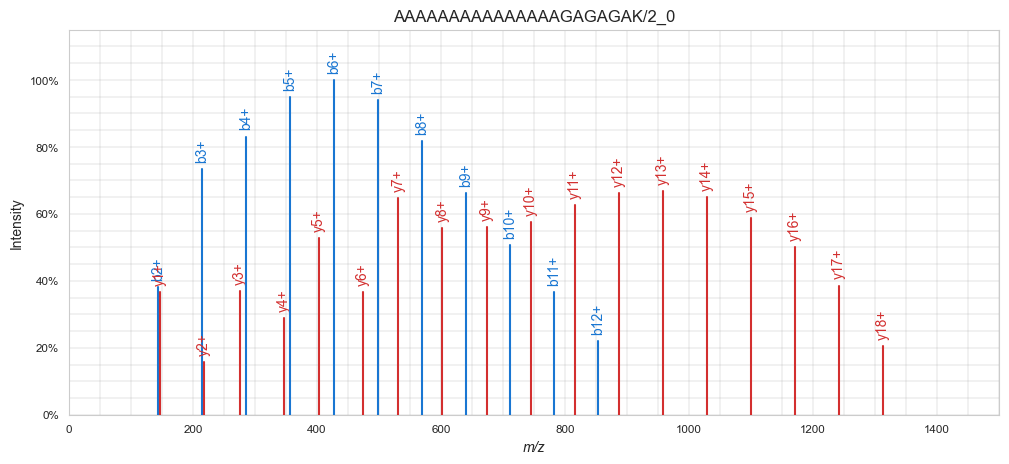

In [17]:
plt.figure(figsize=(12, 5))
sup.spectrum(
    sus.MsmsSpectrum(
        identifier = spectrum['Name'], 
        precursor_mz = float(spectrum['Parent']),
        precursor_charge = int(spectrum['Charge']), 
        mz = spectrum['mz'],
        intensity = spectrum['intensity'],
        peptide = spectrum['sequence']
    ).annotate_peptide_fragments(25, 'ppm')
)
plt.title(spectrum["Name"])
plt.show()

In [18]:
def parse_peaks(msp_spectrum, ion_type):

    # Generate vectorized functions
    get_ions = np.vectorize(lambda x : bool(re.match(f"^({ion_type})([0-9]+)\/", x)))
    get_ions_order = np.vectorize(lambda x : re.match(f"^({ion_type})([0-9]+)\/", x)[2])
    
    # Get mask with requested ion types
    mask = get_ions(msp_spectrum["annotation"])
    
    # Create empty array with all possible ions
    n_ions = len(msp_spectrum["sequence"]) - 1
    parsed_intensity = np.zeros(n_ions)
    
    # Check if any ions of this type are present
    if mask.any():
        # Filter for ion type and sort
        ion_order = get_ions_order(msp_spectrum["annotation"][mask]).astype(int) - 1
        # Add ions to correct position in the array
        parsed_intensity[ion_order] = msp_spectrum["intensity"][mask]
        
    # Error check
    try:
        msp_spectrum["parsed_intensity"][ion_type] = parsed_intensity
    except KeyError:
        msp_spectrum["parsed_intensity"] = {}
        msp_spectrum["parsed_intensity"][ion_type] = parsed_intensity

parse_peaks(spectrum, "b")
parse_peaks(spectrum, "y")

In [19]:
spectrum['parsed_intensity']

{'b': array([0.        , 0.0940595 , 0.18064232, 0.20420307, 0.23347196,
        0.2457854 , 0.23112106, 0.20064339, 0.16306745, 0.1246587 ,
        0.08999325, 0.05416884, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ]),
 'y': array([0.09027135, 0.03876459, 0.09092397, 0.07086667, 0.1299265 ,
        0.09038813, 0.15890096, 0.13701038, 0.13768263, 0.14171469,
        0.15388304, 0.16281605, 0.16425258, 0.15970773, 0.1443574 ,
        0.12279043, 0.09483507, 0.05047642, 0.        , 0.        ,
        0.        ])}

### Parsing the full spectral library

In [20]:
spectrum_list = []
for msp_spectrum in read_msp("human_hcd_tryp_best.msp"):
    # Process intensities
    tic_normalize(msp_spectrum)
    sqrt_transform(msp_spectrum)
    parse_peaks(msp_spectrum, "b")  # Adds `parsed_intensity` > `b`
    parse_peaks(msp_spectrum, "y")  # Adds `parsed_intensity` > `y`

    # Parse metadata
    spectrum = {
        "sequence": msp_spectrum["sequence"],
        "modifications": msp_spectrum["Mods"],
        "charge": int(msp_spectrum["Charge"]),
        "nce": float(msp_spectrum["NCE"]),
        "parsed_intensity": msp_spectrum["parsed_intensity"]
    }

    # Append to list
    spectrum_list.append(spectrum)

/Users/saugatmalla/Library/Mobile 
Documents/com~apple~CloudDocs/Documents/NEU-Courses/Sem_4/Microbe/.venv/lib/python3.10/site-packages/rich/live.py:2
29: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')
Reading... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/2.0 GB -:--:--

In [21]:
spectrum_df = pd.DataFrame(spectrum_list)
spectrum_df

,sequence,modifications,charge,nce,parsed_intensity
0,AAAAAAAAAAAAAAAGAGAGAK,0,2,29.43,"{'b': [0.0, 0.09405950456857681, 0.18064232170..."
1,AAAAAAAAAAAAAAAGAGAGAK,0,3,29.22,"{'b': [0.0, 0.21546243131160736, 0.21998108923..."
2,AAAAAAAAAAAPPAPPEGASPGDSAR,0,2,27.80,"{'b': [0.0, 0.0, 0.056045547127723694, 0.10302..."
3,AAAAAAAAAAAPPAPPEGASPGDSAR,0,3,30.00,"{'b': [0.0, 0.04407356679439545, 0.07545641809..."
4,AAAAAAAAAASGAAIPPLIPPR,0,3,0.00,"{'b': [0.0, 0.10330961644649506, 0.15637055039..."
...,...,...,...,...,...
398368,YYYYHR,0,2,30.20,"{'b': [0.0, 0.14489535987377167, 0.0, 0.0, 0.0..."
398369,YYYYHR,0,3,37.52,"{'b': [0.018267542123794556, 0.076188296079635..."
398370,YYYYMWK,0,2,31.00,"{'b': [0.0, 0.22406582534313202, 0.11588517576..."
398371,YYYYMWK,"1(4,M,Oxidation)",2,30.00,"{'b': [0.0, 0.14110229909420013, 0.0, 0.0, 0.0..."


In [22]:
# Total number of specta
len(spectrum_list)

398373

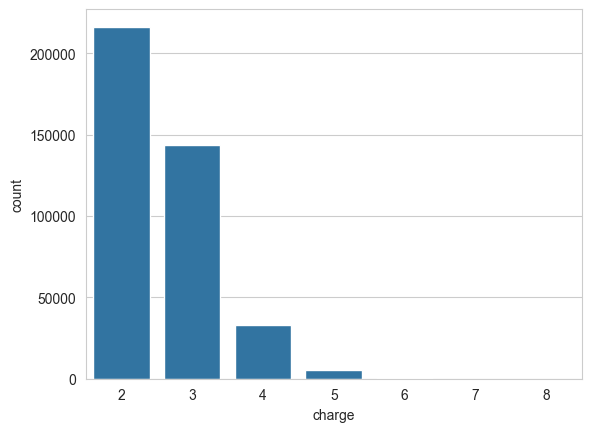

In [23]:
# Precursor charge state
sns.countplot(data=spectrum_df, x="charge")
plt.show()

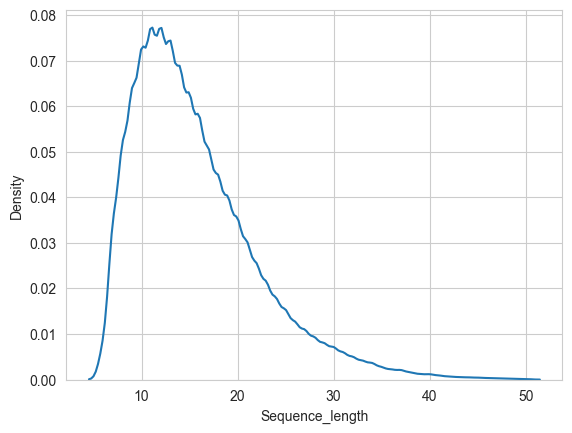

In [24]:
# Peptide length
sns.kdeplot(spectrum_df["sequence"].str.len())
plt.xlabel("Sequence_length")
plt.show()

In [25]:
spectrum_df["sequence"].str.len().describe()

count    398373.000000
mean         15.541467
std           6.506968
min           6.000000
25%          11.000000
50%          14.000000
75%          19.000000
max          50.000000
Name: sequence, dtype: float64

In [26]:
(spectrum_df['sequence'].str.len() > 35).value_counts(normalize=True) 

False    0.98759
True     0.01241
Name: sequence, dtype: float64

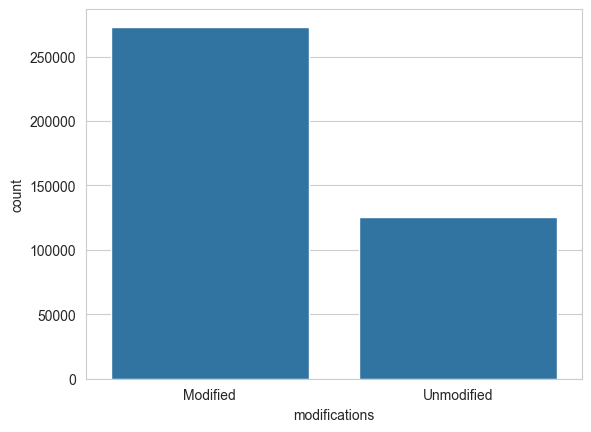

In [27]:
# Peptide modification
modification_state = (spectrum_df["modifications"]=="0").map({True: "Modified", False: "Unmodified"})
sns.countplot(x=modification_state)
plt.show()

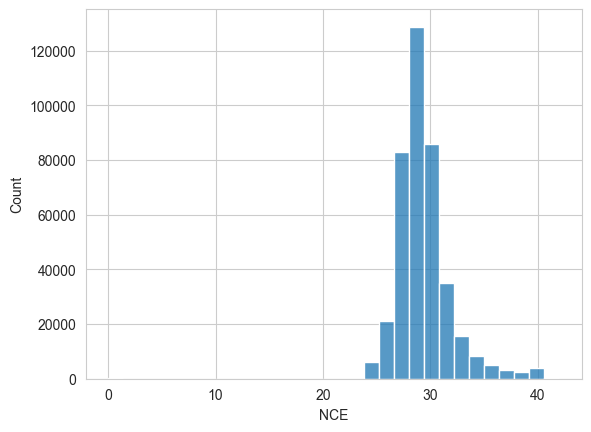

In [28]:
# Collision energy
sns.histplot(spectrum_df["nce"], bins=30)
plt.xlabel("NCE")
plt.show()

In [29]:
(spectrum_df["nce"] == 0.0).value_counts()

False    398103
True        270
Name: nce, dtype: int64

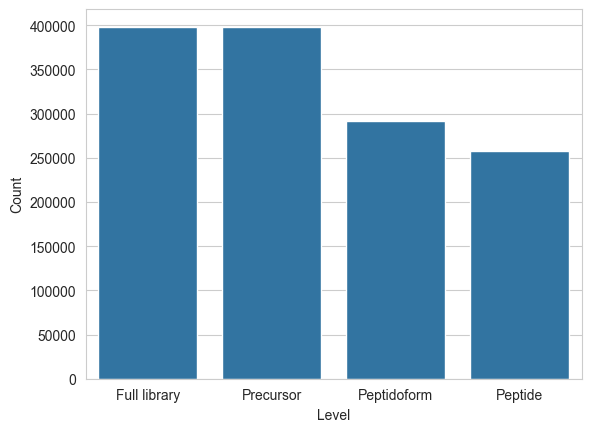

,Level,Count
0,Full library,398373
1,Precursor,398373
2,Peptidoform,292061
3,Peptide,257202


In [30]:
# Duplicate energy
counts = pd.DataFrame({
    "Level": [
        "Full library",
        "Precursor",
        "Peptidoform",
        "Peptide",
    ],
    "Count": [
        spectrum_df.shape[0],
        spectrum_df[["sequence", "modifications", "charge"]].drop_duplicates().shape[0],
        spectrum_df[["sequence", "modifications"]].drop_duplicates().shape[0],
        spectrum_df["sequence"].unique().shape[0],
    ],
})

sns.barplot(data=counts, x="Level", y="Count")
plt.show()

counts

In [31]:
# Selecting data
spectrum_df = spectrum_df[
    (modification_state == "Unmodified") &
    (spectrum_df["sequence"].str.len() <= 35) &
    (spectrum_df["nce"] != 0)
]

In [32]:
spectrum_df.shape[0]

122743

In [33]:
# Train / Validation / Test split

train_val_peptides, test_peptides = train_test_split(spectrum_df["sequence"].unique(), train_size=0.9)
train_val_spectra = spectrum_df[spectrum_df["sequence"].isin(train_val_peptides)]
test_spectra = spectrum_df[spectrum_df["sequence"].isin(test_peptides)]

In [34]:
train_val_spectra.reset_index().to_feather("fragmentation-nist-humanhcd20160503-parsed-trainval.feather")
test_spectra.reset_index().to_feather("fragmentation-nist-humanhcd20160503-parsed-test.feather")

## Gradient Boosting

In [35]:
# Data preparation

# A. Feature Engineering
# 1. Reading the parsed spectral library
train_val_spectra = pd.read_feather("fragmentation-nist-humanhcd20160503-parsed-trainval.feather")
test_spectra = pd.read_feather("fragmentation-nist-humanhcd20160503-parsed-test.feather")

# 2. Feature engineering
amino_acids = list("ACDEFGHIKLMNPQRSTVWY")
properties = np.array([
    [37,35,59,129,94,0,210,81,191,81,106,101,117,115,343,49,90,60,134,104],  # basicity
    [68,23,33,29,70,58,41,73,32,73,66,38,0,40,39,44,53,71,51,55],  # helicity
    [51,75,25,35,100,16,3,94,0,94,82,12,0,22,22,21,39,80,98,70],  # hydrophobicity
    [32,23,0,4,27,32,48,32,69,32,29,26,35,28,79,29,28,31,31,28],  # pI
])

pd.DataFrame(properties, columns=amino_acids, index=["basicity", "helicity", "hydrophobicity", "pI"])


,A,C,D,E,F,G,H,I,K,L,M,N,P,Q,R,S,T,V,W,Y
basicity,37,35,59,129,94,0,210,81,191,81,106,101,117,115,343,49,90,60,134,104
helicity,68,23,33,29,70,58,41,73,32,73,66,38,0,40,39,44,53,71,51,55
hydrophobicity,51,75,25,35,100,16,3,94,0,94,82,12,0,22,22,21,39,80,98,70
pI,32,23,0,4,27,32,48,32,69,32,29,26,35,28,79,29,28,31,31,28


In [36]:
def encode_peptide(sequence, charge):
    # 4 properties * 5 quantiles * 3 ion types + 4 properties * 4 site + 2 global
    n_features = 78
    quantiles = [0, 0.25, 0.5, 0.75, 1]
    n_ions = len(sequence) - 1

    # Encode amino acids as integers to index amino acid properties for peptide sequence
    aa_indices = {aa: i for i, aa in  enumerate("ACDEFGHIKLMNPQRSTVWY")}
    aa_to_index = np.vectorize(lambda aa: aa_indices[aa])
    peptide_indexed = aa_to_index(np.array(list(sequence)))
    peptide_properties = properties[:, peptide_indexed]

    # Empty peptide_features array
    peptide_features = np.full((n_ions, n_features), np.nan)

    for b_ion_number in range(1, n_ions + 1):
        # Calculate quantiles of features across peptide, b-ion, and y-ion
        peptide_quantiles = np.hstack(
            np.quantile(peptide_properties, quantiles, axis=1).transpose()
        )
        b_ion_quantiles = np.hstack(
            np.quantile(peptide_properties[:,:b_ion_number], quantiles, axis=1).transpose()
        )
        y_ion_quantiles = np.hstack(
            np.quantile(peptide_properties[:,b_ion_number:], quantiles, axis=1).transpose()
        )

        # Properties on specific sites: nterm, frag-1, frag+1, cterm
        specific_site_indexes = np.array([0, b_ion_number - 1, b_ion_number, -1])
        specific_site_properties = np.hstack(peptide_properties[:, specific_site_indexes].transpose())

        # Global features: Length and charge
        global_features = np.array([len(sequence), int(charge)])

        # Assign to peptide_features array
        peptide_features[b_ion_number - 1, 0:20] = peptide_quantiles
        peptide_features[b_ion_number - 1, 20:40] = b_ion_quantiles
        peptide_features[b_ion_number - 1, 40:60] = y_ion_quantiles
        peptide_features[b_ion_number - 1, 60:76] = specific_site_properties
        peptide_features[b_ion_number - 1, 76:78] = global_features

    return peptide_features


def generate_feature_names():
    feature_names = []
    for level in ["peptide", "b", "y"]:
        for aa_property in ["basicity", "helicity", "hydrophobicity", "pi"]:
            for quantile in ["min", "q1", "q2", "q3", "max"]:
                feature_names.append("_".join([level, aa_property, quantile]))
    for site in ["nterm", "fragmin1", "fragplus1", "cterm"]:
        for aa_property in ["basicity", "helicity", "hydrophobicity", "pi"]:
            feature_names.append("_".join([site, aa_property]))

    feature_names.extend(["length", "charge"])
    return feature_names

In [37]:
# B. Getting the target intensities
test_spectrum = train_val_spectra.iloc[4]
test_spectrum

index                                                              15
sequence                                            AAAAAAALESWQAAAPR
modifications                                           1(0,A,Acetyl)
charge                                                              2
nce                                                             36.17
parsed_intensity    {'b': [0.0, 0.21474890410900116, 0.26449418067...
Name: 4, dtype: object

In [38]:
peptide_targets = pd.DataFrame({
    "b_target": test_spectrum["parsed_intensity"]["b"],
    "y_target": test_spectrum["parsed_intensity"]["y"]
})
peptide_targets

,b_target,y_target
0,0.000000,0.161244
1,0.214749,0.178116
2,0.264494,0.142861
3,0.262492,0.081340
4,0.231090,0.083767
5,0.202896,0.073415
6,0.146343,0.102773
7,0.079329,0.149828
8,0.000000,0.167765
9,0.000000,0.153730


In [39]:
peptide_targets =  pd.DataFrame({
    "b_target": test_spectrum["parsed_intensity"]["b"],
    "y_target": test_spectrum["parsed_intensity"]["y"][::-1],
})
peptide_targets

,b_target,y_target
0,0.000000,0.000000
1,0.214749,0.000000
2,0.264494,0.000000
3,0.262492,0.101941
4,0.231090,0.131138
5,0.202896,0.163314
6,0.146343,0.153730
7,0.079329,0.167765
8,0.000000,0.149828
9,0.000000,0.102773


In [40]:
features = encode_peptide(test_spectrum["sequence"], test_spectrum["charge"])
targets = np.stack([test_spectrum["parsed_intensity"]["b"], test_spectrum["parsed_intensity"]["y"][::-1]], axis=1)
spectrum_id = np.full(shape=(targets.shape[0], 1), fill_value=test_spectrum["index"])  # Repeat id for all ions

In [41]:
pd.DataFrame(np.hstack([spectrum_id, features, targets]), columns=["spectrum_id"] + generate_feature_names() + ["b_target",  "y_target"])

,spectrum_id,peptide_basicity_min,peptide_basicity_q1,peptide_basicity_q2,peptide_basicity_q3,peptide_basicity_max,peptide_helicity_min,peptide_helicity_q1,peptide_helicity_q2,peptide_helicity_q3,...,fragplus1_hydrophobicity,fragplus1_pi,cterm_basicity,cterm_helicity,cterm_hydrophobicity,cterm_pi,length,charge,b_target,y_target
0,15.0,37.0,37.0,37.0,115.0,343.0,0.0,44.0,68.0,68.0,...,51.0,32.0,343.0,39.0,22.0,79.0,17.0,2.0,0.000000,0.000000
1,15.0,37.0,37.0,37.0,115.0,343.0,0.0,44.0,68.0,68.0,...,51.0,32.0,343.0,39.0,22.0,79.0,17.0,2.0,0.214749,0.000000
2,15.0,37.0,37.0,37.0,115.0,343.0,0.0,44.0,68.0,68.0,...,51.0,32.0,343.0,39.0,22.0,79.0,17.0,2.0,0.264494,0.000000
3,15.0,37.0,37.0,37.0,115.0,343.0,0.0,44.0,68.0,68.0,...,51.0,32.0,343.0,39.0,22.0,79.0,17.0,2.0,0.262492,0.101941
4,15.0,37.0,37.0,37.0,115.0,343.0,0.0,44.0,68.0,68.0,...,51.0,32.0,343.0,39.0,22.0,79.0,17.0,2.0,0.231090,0.131138
5,15.0,37.0,37.0,37.0,115.0,343.0,0.0,44.0,68.0,68.0,...,51.0,32.0,343.0,39.0,22.0,79.0,17.0,2.0,0.202896,0.163314
6,15.0,37.0,37.0,37.0,115.0,343.0,0.0,44.0,68.0,68.0,...,94.0,32.0,343.0,39.0,22.0,79.0,17.0,2.0,0.146343,0.153730
7,15.0,37.0,37.0,37.0,115.0,343.0,0.0,44.0,68.0,68.0,...,35.0,4.0,343.0,39.0,22.0,79.0,17.0,2.0,0.079329,0.167765
8,15.0,37.0,37.0,37.0,115.0,343.0,0.0,44.0,68.0,68.0,...,21.0,29.0,343.0,39.0,22.0,79.0,17.0,2.0,0.000000,0.149828
9,15.0,37.0,37.0,37.0,115.0,343.0,0.0,44.0,68.0,68.0,...,98.0,31.0,343.0,39.0,22.0,79.0,17.0,2.0,0.000000,0.102773


In [42]:
def generate_ml_input(spectra):
    tables = []
    for spectrum in progress.track(spectra.to_dict(orient="records")):
        features = encode_peptide(spectrum["sequence"], spectrum["charge"])
        targets = np.stack([spectrum["parsed_intensity"]["b"], spectrum["parsed_intensity"]["y"][::-1]], axis=1)
        spectrum_id = np.full(shape=(targets.shape[0], 1), fill_value=spectrum["index"])  # Repeat id for all ions
        table = np.hstack([spectrum_id, features, targets])
        tables.append(table)

    full_table = np.vstack(tables)
    spectra_encoded = pd.DataFrame(full_table, columns=["spectrum_id"] + generate_feature_names() + ["b_target",  "y_target"])
    return spectra_encoded

In [43]:
train_val_encoded = generate_ml_input(train_val_spectra)
train_val_encoded.to_feather("fragmentation-nist-humanhcd20160503-parsed-trainval-encoded.feather")

test_encoded = generate_ml_input(test_spectra)
test_encoded.to_feather("fragmentation-nist-humanhcd20160503-parsed-test-encoded.feather")

/Users/saugatmalla/Library/Mobile 
Documents/com~apple~CloudDocs/Documents/NEU-Courses/Sem_4/Microbe/.venv/lib/python3.10/site-packages/rich/live.py:2
29: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/Users/saugatmalla/Library/Mobile 
Documents/com~apple~CloudDocs/Documents/NEU-Courses/Sem_4/Microbe/.venv/lib/python3.10/site-packages/rich/live.py:2
29: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

In [44]:
train_val_encoded

,spectrum_id,peptide_basicity_min,peptide_basicity_q1,peptide_basicity_q2,peptide_basicity_q3,peptide_basicity_max,peptide_helicity_min,peptide_helicity_q1,peptide_helicity_q2,peptide_helicity_q3,...,fragplus1_hydrophobicity,fragplus1_pi,cterm_basicity,cterm_helicity,cterm_hydrophobicity,cterm_pi,length,charge,b_target,y_target
0,6.0,0.0,37.0,43.0,111.5,191.0,0.0,40.0,63.0,68.0,...,51.0,32.0,191.0,32.0,0.0,69.0,18.0,2.0,0.000000,0.000000
1,6.0,0.0,37.0,43.0,111.5,191.0,0.0,40.0,63.0,68.0,...,51.0,32.0,191.0,32.0,0.0,69.0,18.0,2.0,0.148589,0.000000
2,6.0,0.0,37.0,43.0,111.5,191.0,0.0,40.0,63.0,68.0,...,51.0,32.0,191.0,32.0,0.0,69.0,18.0,2.0,0.261777,0.068181
3,6.0,0.0,37.0,43.0,111.5,191.0,0.0,40.0,63.0,68.0,...,51.0,32.0,191.0,32.0,0.0,69.0,18.0,2.0,0.312184,0.123198
4,6.0,0.0,37.0,43.0,111.5,191.0,0.0,40.0,63.0,68.0,...,51.0,32.0,191.0,32.0,0.0,69.0,18.0,2.0,0.321556,0.178683
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1716726,398371.0,104.0,104.0,104.0,120.0,191.0,32.0,53.0,55.0,55.0,...,70.0,28.0,191.0,32.0,0.0,69.0,7.0,2.0,0.141102,0.262544
1716727,398371.0,104.0,104.0,104.0,120.0,191.0,32.0,53.0,55.0,55.0,...,70.0,28.0,191.0,32.0,0.0,69.0,7.0,2.0,0.000000,0.159507
1716728,398371.0,104.0,104.0,104.0,120.0,191.0,32.0,53.0,55.0,55.0,...,82.0,29.0,191.0,32.0,0.0,69.0,7.0,2.0,0.000000,0.133702
1716729,398371.0,104.0,104.0,104.0,120.0,191.0,32.0,53.0,55.0,55.0,...,98.0,31.0,191.0,32.0,0.0,69.0,7.0,2.0,0.000000,0.147241


In [45]:
# 3. Training the model
reg =  GradientBoostingRegressor()

X_train = train_val_encoded.drop(columns=["spectrum_id", "b_target",  "y_target"])
y_train = train_val_encoded["y_target"]
X_test = test_encoded.drop(columns=["spectrum_id", "b_target",  "y_target"])
y_test = test_encoded["y_target"]

reg.fit(X_train, y_train)

GradientBoostingRegressor()

In [46]:
y_test_pred = reg.predict(X_test)
np.corrcoef(y_test, y_test_pred)[0][1]

0.7524085013195408

In [47]:
# Hyperparameter optimization
def objective(n_estimators):
    # Define algorithm
    reg =  GradientBoostingRegressor(n_estimators=n_estimators)

    # Fit model
    reg.fit(X_train, y_train)

    # Test model
    y_test_pred = reg.predict(X_test)
    correlation = np.corrcoef(y_test, y_test_pred)[0][1]

    return {'loss': -correlation, 'status': STATUS_OK} 

In [ ]:
best_params = fmin(
    fn=objective,
    space = 10 + hp.randint('n_estimators', 980), 
    algo = tpe.suggest, 
    max_evals = 10 
)

best_params

  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

In [ ]:
reg =  GradientBoostingRegressor(n_estimators=946)

X_train = train_val_encoded.drop(columns=["spectrum_id", "b_target",  "y_target"])
y_train = train_val_encoded["y_target"]
X_test = test_encoded.drop(columns=["spectrum_id", "b_target",  "y_target"])
y_test = test_encoded["y_target"]

reg.fit(X_train, y_train)

In [ ]:
y_test_pred = reg.predict(X_test)

np.corrcoef(y_test, y_test_pred)[0][1]

In [ ]:
prediction_df_y = pd.DataFrame({
    "spectrum_id": test_encoded['spectrum_id'] ,
    "target_y": y_test,
    "prediction_y": y_test_pred
})

In [ ]:
corr_y = prediction_df_y.groupby("spectrum_id").corr().iloc[::2]['prediction_y']
corr_y.index = corr_y.index.droplevel(1)
corr_y = corr_y.reset_index().rename(columns={"prediction_y": "correlation"})
corr_y

In [ ]:
corr_y["correlation"].median()

In [ ]:
sns.catplot(
    data=corr_y, x="correlation", 
    fliersize=1, 
    kind = 'box', aspect=4, height=2
)
plt.show()